`ProPublica Recidivism/COMPAS` :<br>
    The COMPAS dataset (Correctional Offender Management Profiling for Alternative Sanctions) is a dataset used for binary classification tasks in the field of criminal justice. The goal is to predict whether a defendant will re-offend within two years of release, based on various demographic and criminal history features.<br>
    Reference Link: https://www.propublica.org/datastore/dataset/compas-recidivism-risk-score-data-and-analysis

In [1]:
import pandas as pd
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..', '..'))
if module_path not in sys.path:
    sys.path.append(module_path)\

import facts
from facts.clean import clean_dataset
from facts import valid_ifthens_with_coverage_correctness, rules2rulesbyif
from facts.models import customLogisticRegression
from facts.parameters import ParameterProxy
from facts.formatting import recourse_report_reverse, print_recourse_report, print_recourse_report_cumulative, print_recourse_report_KStest_cumulative
from facts.utils import load_rules_by_if
from aif360.sklearn.datasets import fetch_compas
from facts.fairness_metrics_aggr import get_diff_table, get_comb_df, get_analysis_dfs, get_diff_real_diff_drop,get_other_ranks_divided,get_map_metric_to_max_rank
import warnings
warnings.filterwarnings('ignore')

In [7]:
from pathlib import Path

computed_rules_file = Path("..") / "results-cache" / "Compas" / "rulesCompas_atomic.data"
computed_rules_with_cumulative_file = Path("..") / "results-cache" / "Compas" / "rulesCompas_cumulative.data"

In [8]:
cost_budget = 10
top_count = 20
c_inf = 5

In [9]:
X, y = fetch_compas()
X['target'] = y.values

sensitive_attribute = "race"
df = clean_dataset(X,'compas')
y = df['target']
X = df.drop('target', axis=1)

X.head()

,sex,age_cat,race,juv_fel_count,juv_misd_count,juv_other_count,priors_count,c_charge_degree
0,Male,25 - 45,African-American,0,0,0,"(-0.1, 1.0]",F
1,Male,10-25,African-American,0,0,1,"(1.0, 5.0]",F
2,Male,25 - 45,Caucasian,0,0,0,"(10.0, 15.0]",F
3,Female,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",M
4,Male,25 - 45,Caucasian,0,0,0,"(-0.1, 1.0]",F


In [10]:
rules_with_atomic_correctness = load_rules_by_if(computed_rules_file)
rules_with_cumulative_correctness = load_rules_by_if(computed_rules_with_cumulative_file)

In [11]:
num_features = X._get_numeric_data().columns.to_list()
cate_features = X.select_dtypes(include=['object','category']).columns.to_list()
ord_features = []
feature_weights = {'sex':100,	'age_cat':10,	'race':100,	'juv_fel_count':1,	'juv_fel_count':1,	'juv_other_count':1,	'priors_count':1,	'c_charge_degree':1}

features_with_binary_cost = cate_features
features_with_proportional_cost = num_features


comparators = facts.feature_change_builder(
    X,
    num_cols=features_with_proportional_cost,
    cate_cols=features_with_binary_cost,
    ord_cols=ord_features,
    feature_weights=feature_weights,
    num_normalization=False,
    #feats_to_normalize = ["capital-gain","capital-loss"]
)
params = ParameterProxy(featureChanges=comparators)
facts.update_costs_cumulative(rules_with_cumulative_correctness, params)

# Macro Viewpoint

## Equal Cost of Effectiveness (Macro)

In [12]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="min-above-thr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=50,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules",
        "keep-only-min-change"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Cost of Effectiveness (threshold = 0.7)'
)

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 21.54% covered
		Make c_charge_degree = M with effectiveness 71.43%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 20.89% covered
		Make age_cat = Greater than 45 with effectiveness 90.74%.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Cost of Effectiveness (threshold = 0.7). Unfairness score = 9.
If age_cat = 10-25, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 21.03% covered
		Make c_charge_degree = M with effectiveness 73.17%.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 20.12% covered
		Make age_cat = 25 - 45 with effectiveness 73.08%.
		Make age_cat = Greater than 45 with effectiveness 93.27%.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equa

## Equal Choice for Recourse(Macro)

In [13]:
top_rules, subgroup_costs = facts.select_rules_subset(
    rules_with_atomic_correctness,
    metric="num-above-thr",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=50,
    cor_threshold=0.7,
    filter_sequence = [
        "remove-contained",
        "remove-below-thr",
        # "remove-fair-rules"
    ],
    params=params
)

print_recourse_report(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    metric_name = 'Equal Choice for Recourse (threshold = 0.7)'
)

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00%.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 75.00%.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00%.
		Aggregate cost of the above recourses = -3.00
	Protected Subgroup 'African-American', 3.87% covered
		No recourses for this subgroup!
		Aggregate cost of the above recourses = 0.00
	Bias against African-American due to Equal Choice for Recourse (threshold = 0.7). Unfairness score = 3.
If age_cat = 10-25, c_charge_degree = F, sex = Female:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 100.00%.
		Aggregate cost of the above recourses = -1.00
	Protected Subgroup 'African-American', 1.55% covered
		Make age_cat = 25 - 45 with effectiveness 87.50%.
		Mak

# Micro Viewpoint

## Equal Conditional Mean Recourse

If age_cat = 25 - 45, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup 'African-American', 1.55% covered
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 9.50
	Bias against African-American due to Equal Effectiveness. Unfairness score = 7.5.
	Cumulative effectiveness plot for the above recourses:


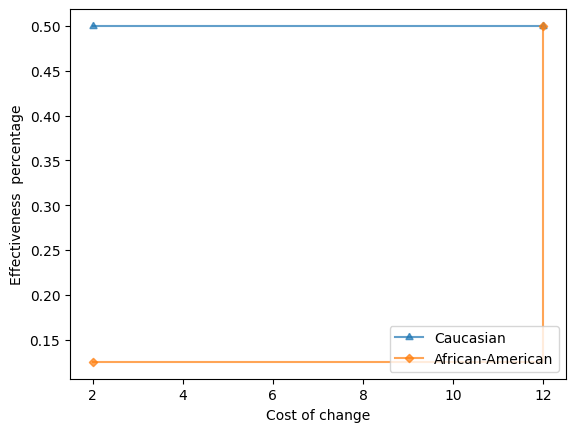

If age_cat = 25 - 45, juv_misd_count = 0, juv_other_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'African-American', 3.87% covered
		Make juv_other_count = 0 with effectiveness 20.00% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 35.00% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 5.29
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 5.714.
	Cumulative effectiveness plot for the above recourses:


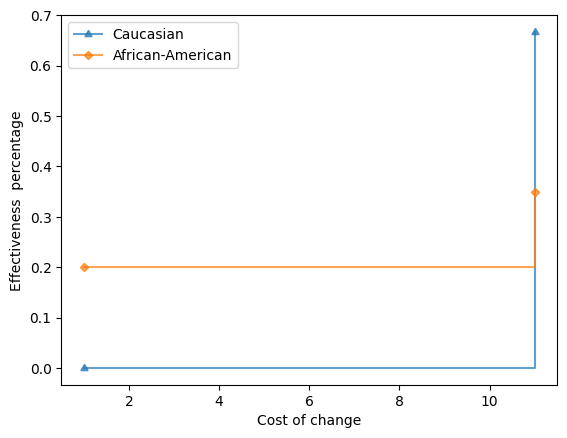

If age_cat = 10-25, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 2.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 11.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 11.
		Make age_cat = 25 - 45, juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 100.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 5.00
	Protected Subgroup 'African-American', 1.93% covered
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 2.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 20.00% and count

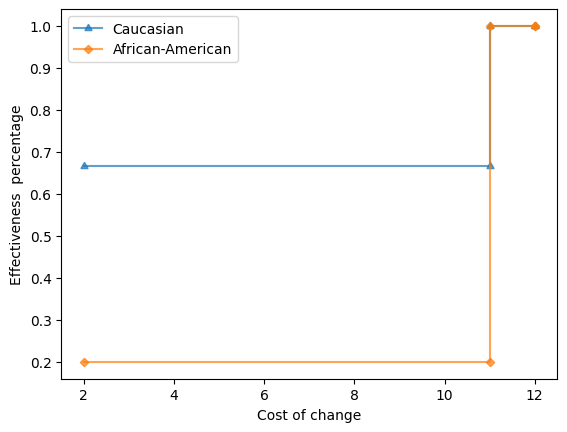

If age_cat = 10-25, juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 1.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 11.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 11.
		Make age_cat = 25 - 45, juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 100.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 6.00
	Protected Subgroup 'African-American', 2.32% covered
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 1.
		Make age_cat = 25 - 45, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 11.
		Make age_cat = Greate

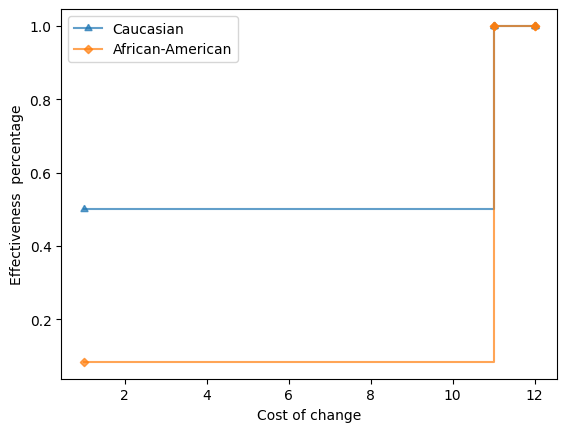

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 2.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 11.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'African-American', 2.71% covered
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 42.86% and counterfactual cost = 2.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 42.86% and counterfactual cost 

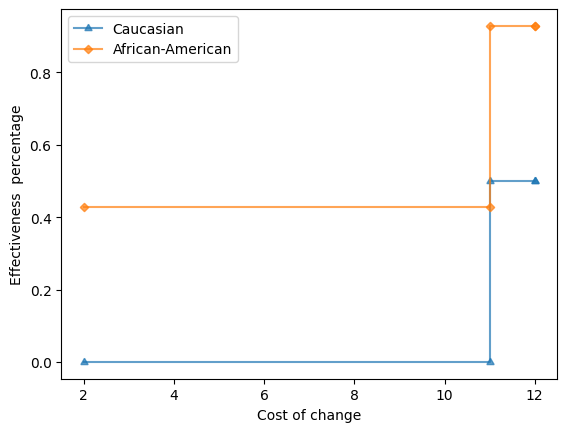

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_fel_count = 0 with effectiveness 25.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup 'African-American', 3.68% covered
		Make juv_fel_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_fel_count = 0 with effectiveness 31.58% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_fel_count = 0 with effectiveness 36.84% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_fel_count = 0 with effecti

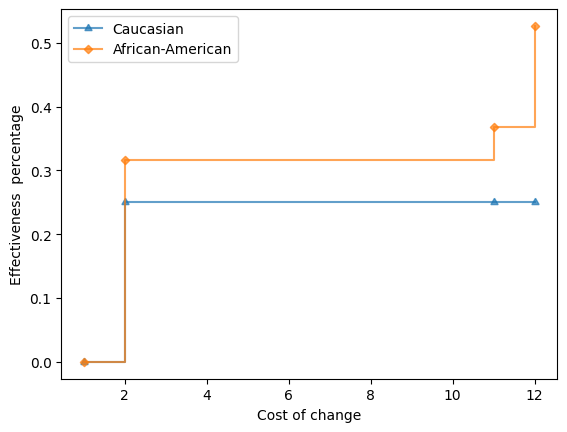

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup 'African-American', 3.68% covered
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 26.32% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 26.32% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M, ju

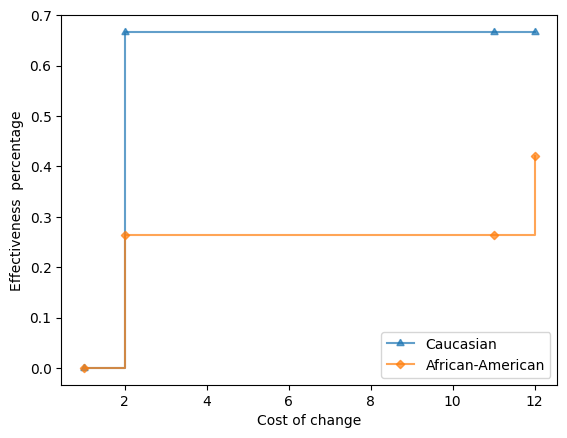

In [14]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="fairness-of-mean-recourse-conditional",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Equal Cost of Effectiveness (Micro)

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 21.54% covered
		Make c_charge_degree = M with effectiveness 71.43% and counterfactual cost = 1.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 20.89% covered
		Make c_charge_degree = M with effectiveness 67.59% and counterfactual cost = 1.
		Make age_cat = 25 - 45 with effectiveness 67.59% and counterfactual cost = 10.
		Make age_cat = Greater than 45 with effectiveness 90.74% and counterfactual cost = 10.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.
	Cumulative effectiveness plot for the above recourses:


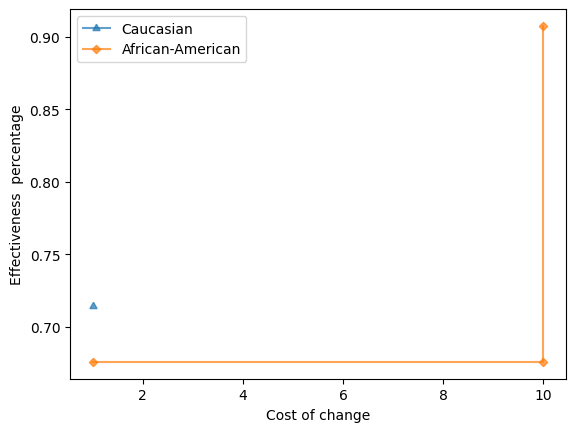

If age_cat = 10-25, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 21.03% covered
		Make c_charge_degree = M with effectiveness 73.17% and counterfactual cost = 1.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 20.12% covered
		Make c_charge_degree = M with effectiveness 64.42% and counterfactual cost = 1.
		Make age_cat = 25 - 45 with effectiveness 73.08% and counterfactual cost = 10.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.
	Cumulative effectiveness plot for the above recourses:


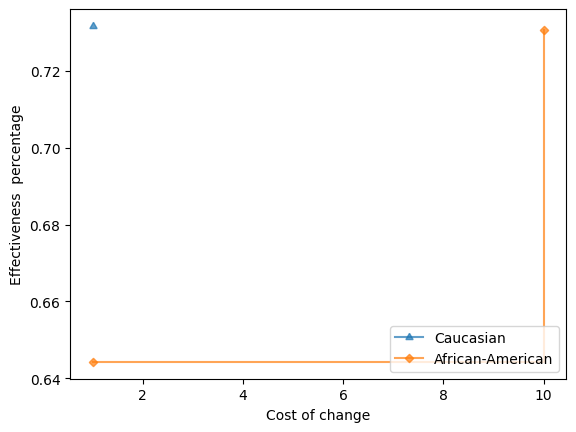

If age_cat = 10-25, c_charge_degree = F, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 2.56% covered
		Make priors_count = (-0.1, 1.0] with effectiveness 40.00% and counterfactual cost = 1.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 80.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup 'African-American', 2.51% covered
		Make priors_count = (-0.1, 1.0] with effectiveness 15.38% and counterfactual cost = 1.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 69.23% and counterfactual cost = 2.
		Make age_cat = 25 - 45, priors_count = (1.0, 5.0] with effectiveness 69.23% and counterfactual cost = 11.
		Make age_cat = 25 - 45, priors_count = (-0.1, 1.0] with effectiveness 84.62% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 11.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 9.
	Cumulative effectiveness plot for the 

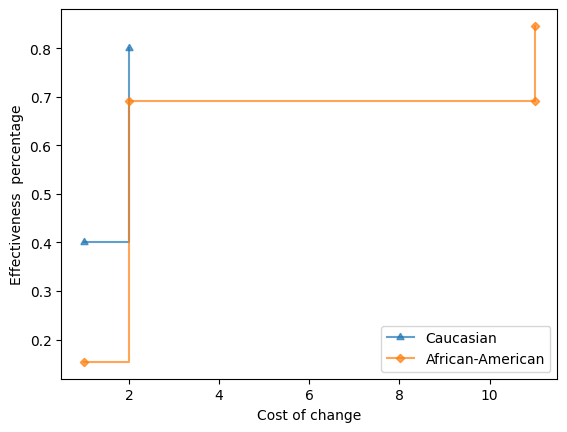

If age_cat = 10-25, c_charge_degree = F, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 7.18% covered
		Make priors_count = (-0.1, 1.0] with effectiveness 21.43% and counterfactual cost = 1.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 71.43% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 2.00
	Protected Subgroup 'African-American', 9.48% covered
		Make priors_count = (-0.1, 1.0] with effectiveness 18.37% and counterfactual cost = 1.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 63.27% and counterfactual cost = 2.
		Make age_cat = 25 - 45 with effectiveness 63.27% and counterfactual cost = 10.
		Make age_cat = Greater than 45 with effectiveness 85.71% and counterfactual cost = 10.
		Aggregate cost of the above recourses = 10.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 8.
	Cumulative effectiveness plot for the above recourses:


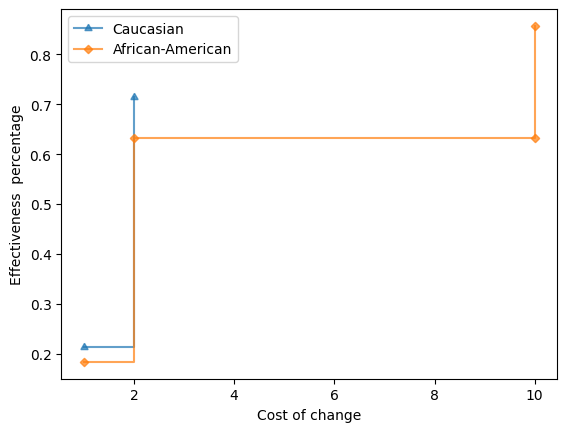

If c_charge_degree = F, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 33.33% covered
		Make c_charge_degree = M with effectiveness 72.31% and counterfactual cost = 1.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 25.73% covered
		Make c_charge_degree = M with effectiveness 53.38% and counterfactual cost = 1.
		Make priors_count = (-0.1, 1.0] with effectiveness 69.92% and counterfactual cost = 1.
		Make c_charge_degree = M, priors_count = (-0.1, 1.0] with effectiveness 86.47% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 2.00
	Bias against African-American due to Equal Effectiveness. Unfairness score = 1.
	Cumulative effectiveness plot for the above recourses:


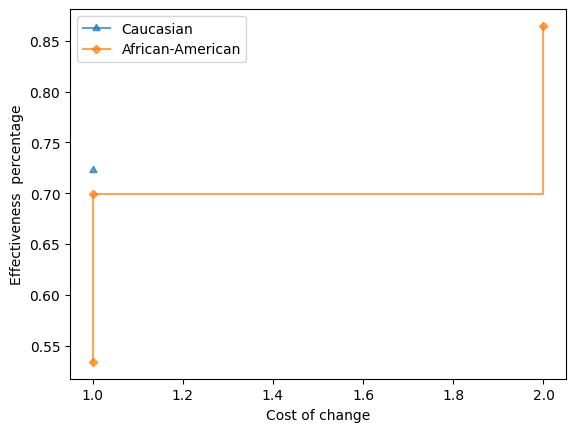

If age_cat = 10-25, c_charge_degree = F, sex = Female:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make c_charge_degree = M with effectiveness 0.00% and counterfactual cost = 1.
		Make age_cat = 25 - 45 with effectiveness 66.67% and counterfactual cost = 10.
		Make age_cat = Greater than 45 with effectiveness 66.67% and counterfactual cost = 10.
		Make age_cat = 25 - 45, c_charge_degree = M with effectiveness 66.67% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 100.00% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 11.00
	Protected Subgroup 'African-American', 1.55% covered
		Make c_charge_degree = M with effectiveness 12.50% and counterfactual cost = 1.
		Make age_cat = 25 - 45 with effectiveness 87.50% and counterfactual cost = 10.
		Aggregate cost of the above recourses = 10.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 1.
	Cumulative effectiveness plot for the above re

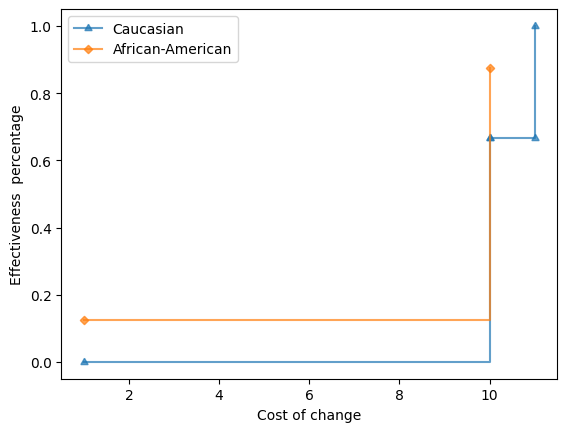

In [15]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="min-above-corr",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cor_threshold = 0.7,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "keep-cheap-rules-above-thr-cor",
        
        
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Equal Effectiveness

If juv_other_count = 3:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.16% covered
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.667.
	Cumulative effectiveness plot for the above recourses:


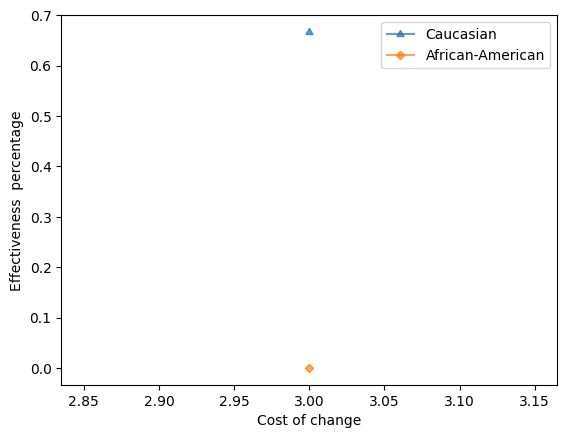

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 2.
		Make age_cat = 25 - 45, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 11.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.
		Make age_cat = 25 - 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.90% covered
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_misd_count = 0 wit

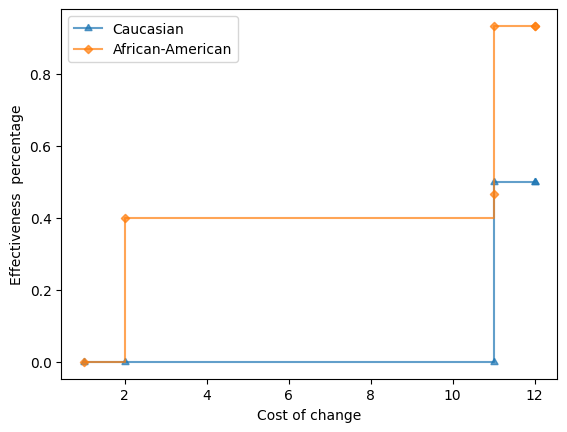

If juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 1.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 1.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 8.33% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.08
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


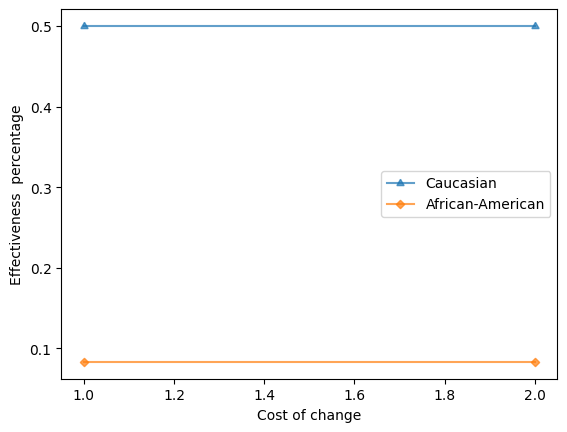

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 12.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 2.32% covered
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 2.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 11.
		Make age_cat = Greater than 45, c_charge_degre

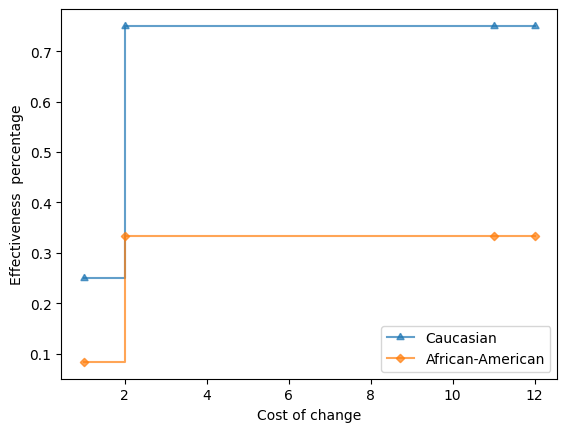

If age_cat = 25 - 45, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 6.38% covered
		Make juv_other_count = 0 with effectiveness 15.15% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 33.33% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 0.33
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


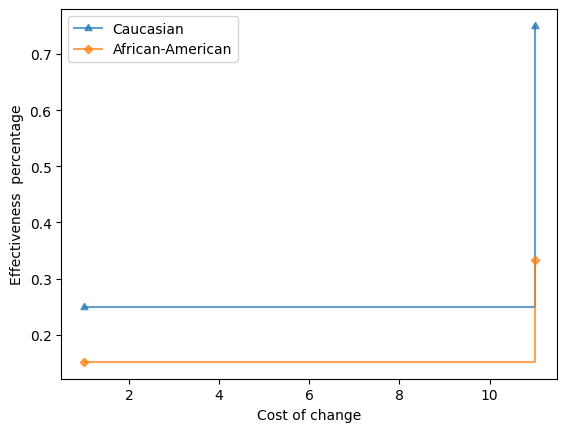

If c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 0.00% and counterfactual cost = 2.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 3.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 1.93% covered
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 10.00% and counterfactual cost = 2.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 80.00% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 

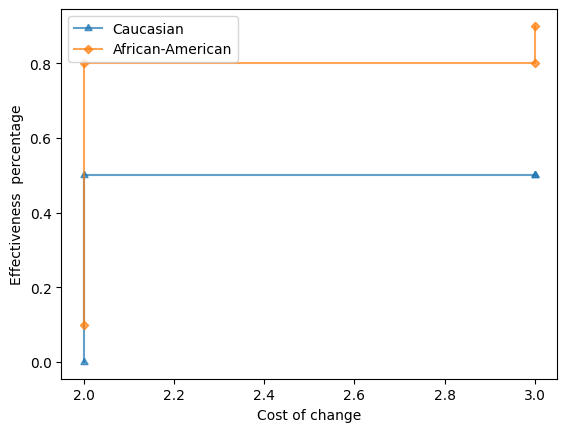

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 2:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 3.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_count = 0 with effectiveness 100.00% and counterfactual cost = 13.
		Aggregate cost of the above recourses = 1.00
	Protected Subgroup 'African-American', 1.55% covered
		Make juv_other_count = 0 with effectiveness 12.50% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 37.50% and counterfactual cost = 3.
		Make age_cat = Greater than 45, juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 12.
		Make age_cat = Greater than 45, c_charge_degree = M, juv_other_c

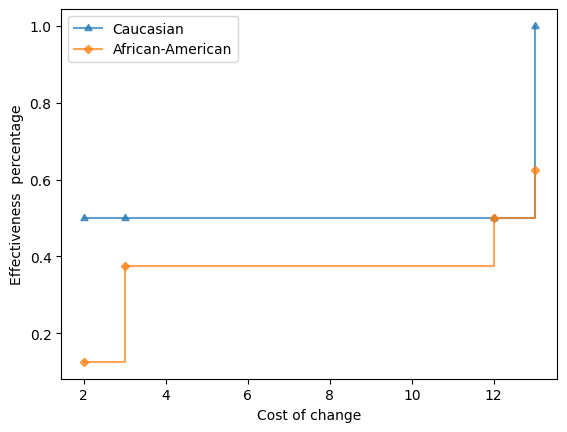

If age_cat = 25 - 45, juv_fel_count = 0, juv_misd_count = 1, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 50.00% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 4.06% covered
		Make juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 1.
		Make age_cat = Greater than 45, juv_misd_count = 0 with effectiveness 14.29% and counterfactual cost = 11.
		Aggregate cost of the above recourses = 0.14
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.357.
	Cumulative effectiveness plot for the above recourses:


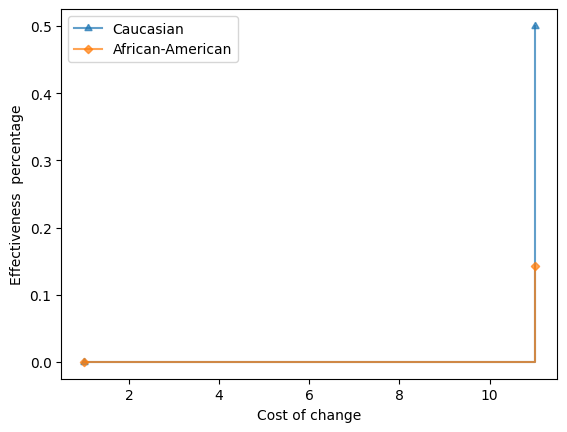

In [16]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="total-correctness",
    sort_strategy="generic-sorting-ignore-forall-subgroups-empty",
    top_count=top_count,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Fair Effectiveness-Cost Trade-Off

If age_cat = 25 - 45, c_charge_degree = F, sex = Male:
	Protected Subgroup 'Caucasian', 43.59% covered out of 262
		Make c_charge_degree = M with effectiveness 54.12% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 57.65% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 70.59% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 44.10% covered out of 483
		Make c_charge_degree = M with effectiveness 31.14% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 35.96% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 38.60% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.76.
	Cumulative effectiveness plot for the above recourses:


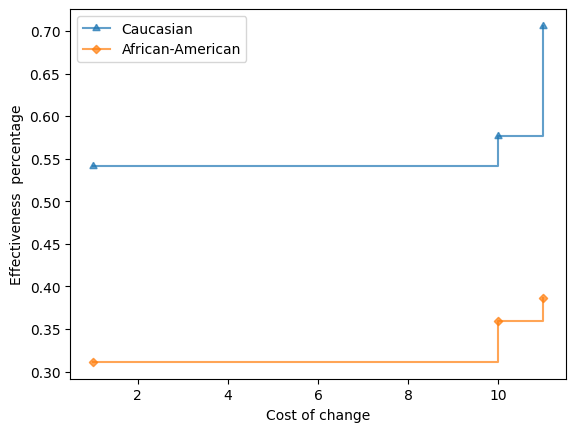

If age_cat = 25 - 45, c_charge_degree = F:
	Protected Subgroup 'Caucasian', 46.67% covered out of 262
		Make c_charge_degree = M with effectiveness 51.65% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.44% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 72.53% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 47.97% covered out of 483
		Make c_charge_degree = M with effectiveness 29.03% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 39.52% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 41.94% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.74.
	Cumulative effectiveness plot for the above recourses:


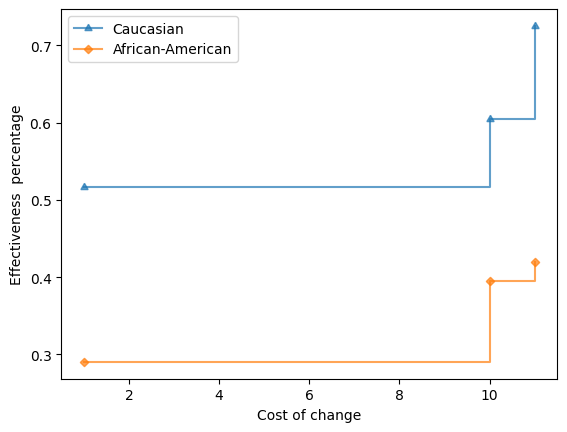

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 41.54% covered out of 262
		Make c_charge_degree = M with effectiveness 56.79% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 58.02% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 71.60% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 38.10% covered out of 483
		Make c_charge_degree = M with effectiveness 35.53% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 38.58% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 40.61% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.56.
	Cumulative effectiveness plot for the above recourses:


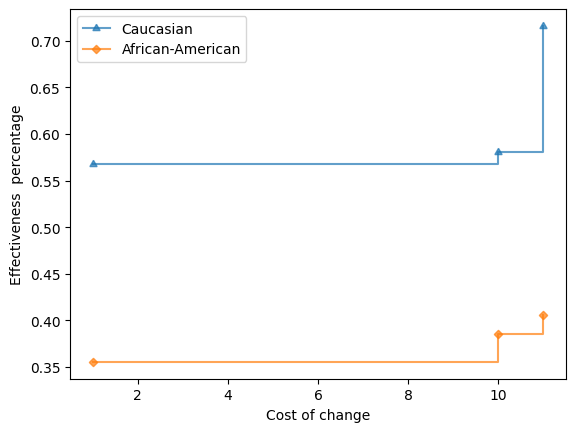

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 41.54% covered out of 262
		Make c_charge_degree = M with effectiveness 56.79% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 59.26% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 72.84% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 37.72% covered out of 483
		Make c_charge_degree = M with effectiveness 36.41% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 38.97% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 42.05% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.54.
	Cumulative effectiveness plot for the above recourses:


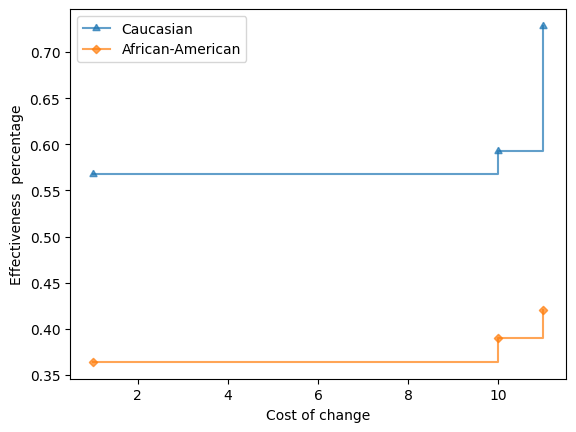

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0:
	Protected Subgroup 'Caucasian', 44.62% covered out of 262
		Make c_charge_degree = M with effectiveness 54.02% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 62.07% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 74.71% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 41.39% covered out of 483
		Make c_charge_degree = M with effectiveness 33.64% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 42.99% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 45.79% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.48.
	Cumulative effectiveness plot for the above recourses:


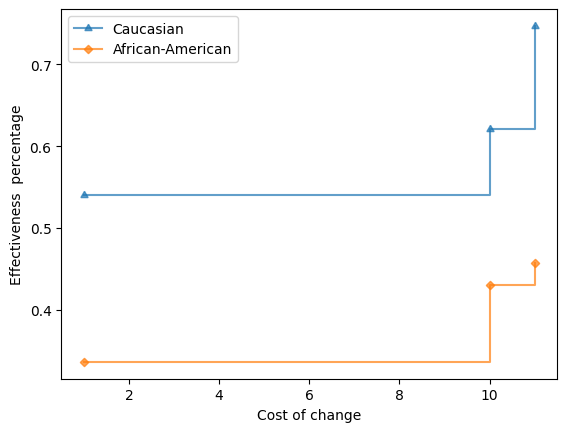

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 43.59% covered out of 262
		Make c_charge_degree = M with effectiveness 54.12% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.00% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 72.94% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 41.59% covered out of 483
		Make c_charge_degree = M with effectiveness 32.56% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 42.33% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 44.19% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.45.
	Cumulative effectiveness plot for the above recourses:


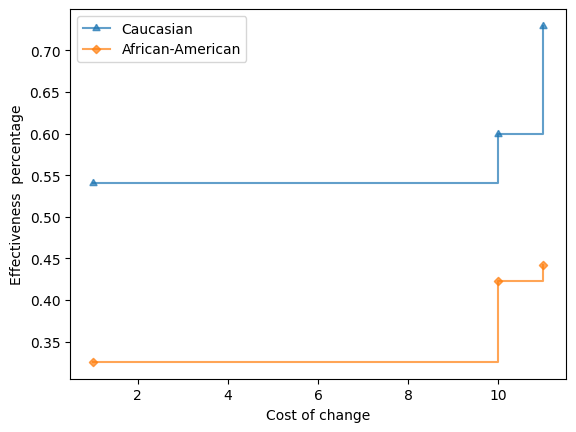

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 39.49% covered out of 262
		Make c_charge_degree = M with effectiveness 59.74% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 59.74% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 74.03% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 33.08% covered out of 483
		Make c_charge_degree = M with effectiveness 40.94% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 40.94% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 43.27% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.44.
	Cumulative effectiveness plot for the above recourses:


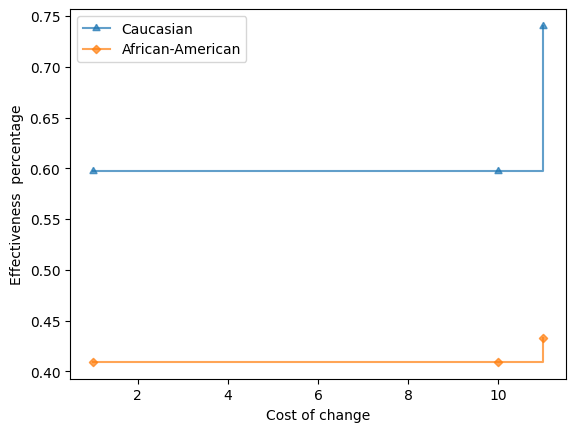

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 43.08% covered out of 262
		Make c_charge_degree = M with effectiveness 54.76% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 58.33% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 70.24% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 36.36% covered out of 483
		Make c_charge_degree = M with effectiveness 37.23% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 40.96% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 40.96% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.43.
	Cumulative effectiveness plot for the above recourses:


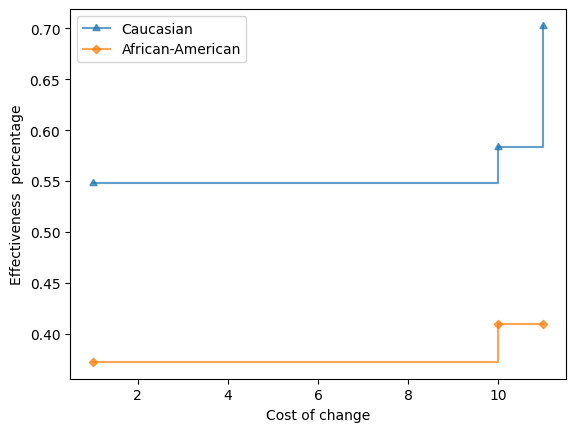

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0:
	Protected Subgroup 'Caucasian', 45.64% covered out of 262
		Make c_charge_degree = M with effectiveness 52.81% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.67% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 71.91% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 39.26% covered out of 483
		Make c_charge_degree = M with effectiveness 34.98% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 44.33% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 44.33% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.36.
	Cumulative effectiveness plot for the above recourses:


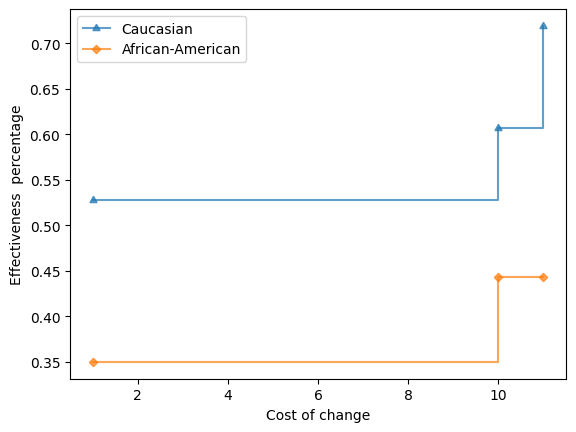

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 41.03% covered out of 262
		Make c_charge_degree = M with effectiveness 57.50% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 58.75% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 71.25% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 33.46% covered out of 483
		Make c_charge_degree = M with effectiveness 39.88% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 42.20% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 42.20% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.33.
	Cumulative effectiveness plot for the above recourses:


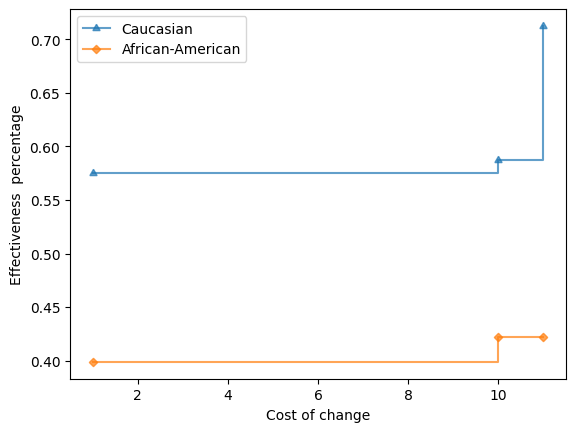

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 41.03% covered out of 262
		Make c_charge_degree = M with effectiveness 57.50% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.00% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 72.50% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 32.50% covered out of 483
		Make c_charge_degree = M with effectiveness 41.67% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 43.45% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 43.45% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.32.
	Cumulative effectiveness plot for the above recourses:


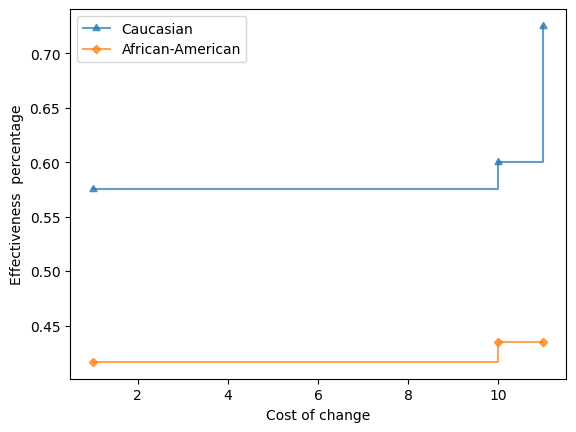

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 41.54% covered out of 262
		Make c_charge_degree = M with effectiveness 56.79% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 61.73% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 75.31% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 36.36% covered out of 483
		Make c_charge_degree = M with effectiveness 37.23% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 45.21% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 47.34% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.29.
	Cumulative effectiveness plot for the above recourses:


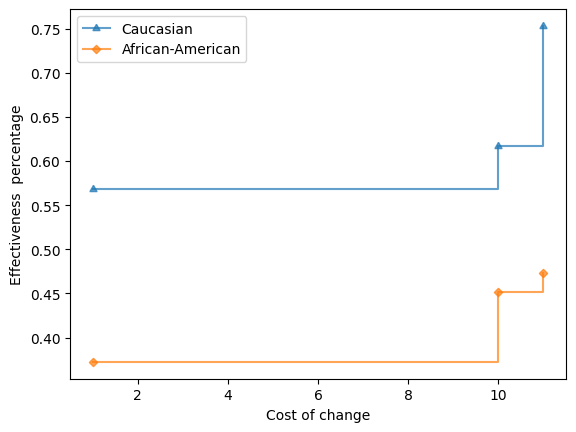

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0, sex = Male:
	Protected Subgroup 'Caucasian', 38.97% covered out of 262
		Make c_charge_degree = M with effectiveness 60.53% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.53% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 73.68% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 29.98% covered out of 483
		Make c_charge_degree = M with effectiveness 44.52% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 44.52% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 44.52% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.26.
	Cumulative effectiveness plot for the above recourses:


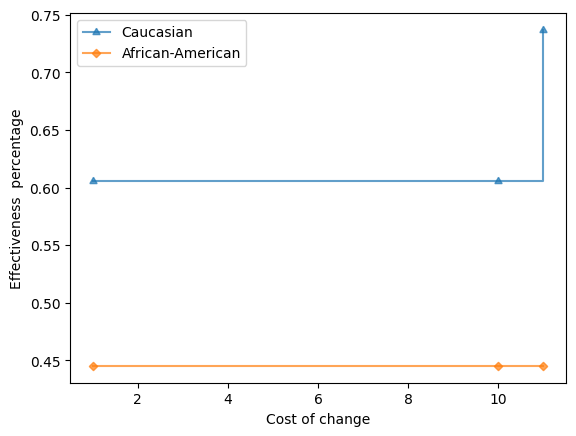

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 0:
	Protected Subgroup 'Caucasian', 43.59% covered out of 262
		Make c_charge_degree = M with effectiveness 55.29% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 62.35% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 74.12% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 35.20% covered out of 483
		Make c_charge_degree = M with effectiveness 39.01% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 47.25% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 47.25% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.22.
	Cumulative effectiveness plot for the above recourses:


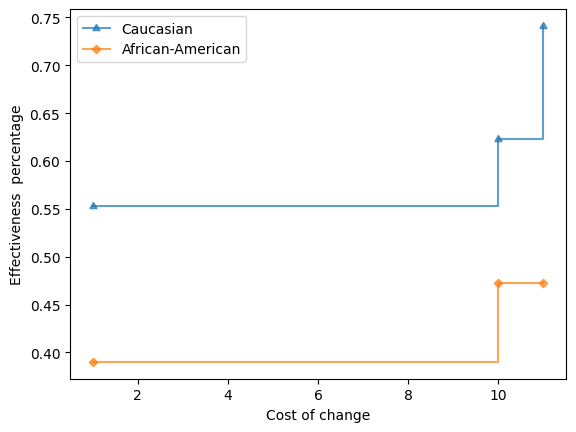

If age_cat = 25 - 45, c_charge_degree = F, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 42.56% covered out of 262
		Make c_charge_degree = M with effectiveness 55.42% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 60.24% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 72.29% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 36.17% covered out of 483
		Make c_charge_degree = M with effectiveness 36.90% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 45.45% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 45.45% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.21.
	Cumulative effectiveness plot for the above recourses:


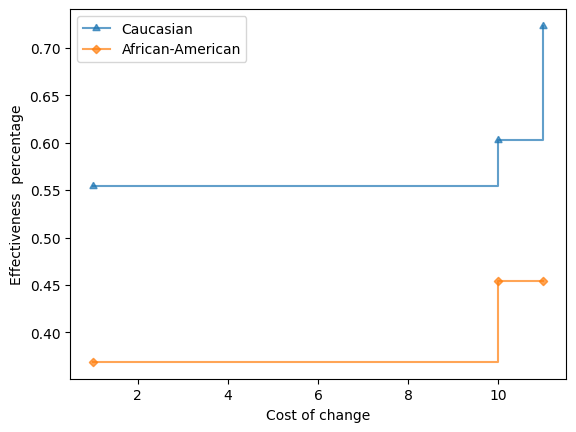

If age_cat = 25 - 45, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 0, juv_other_count = 0:
	Protected Subgroup 'Caucasian', 40.51% covered out of 262
		Make c_charge_degree = M with effectiveness 58.23% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 62.03% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 74.68% and counterfactual cost = 11.
	Protected Subgroup 'African-American', 32.50% covered out of 483
		Make c_charge_degree = M with effectiveness 41.07% and counterfactual cost = 1.
		Make age_cat = Greater than 45 with effectiveness 48.21% and counterfactual cost = 10.
		Make age_cat = Greater than 45, c_charge_degree = M with effectiveness 48.21% and counterfactual cost = 11.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 2.11.
	Cumulative effectiveness plot for the above recourses:


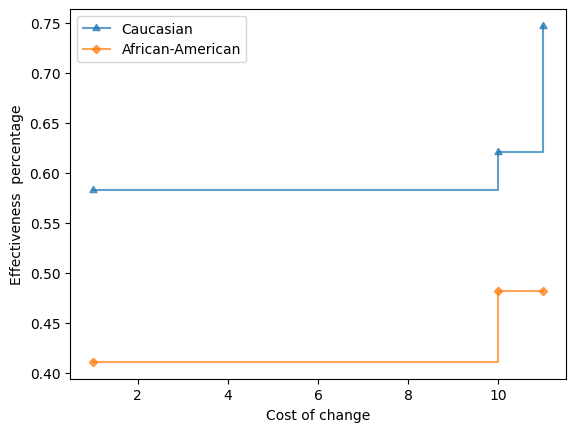

If age_cat = 25 - 45:
	Protected Subgroup 'Caucasian', 53.33% covered out of 262
		Make age_cat = Greater than 45 with effectiveness 56.73% and counterfactual cost = 10.
	Protected Subgroup 'African-American', 55.90% covered out of 483
		Make age_cat = Greater than 45 with effectiveness 36.33% and counterfactual cost = 10.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 1.96.
	Cumulative effectiveness plot for the above recourses:


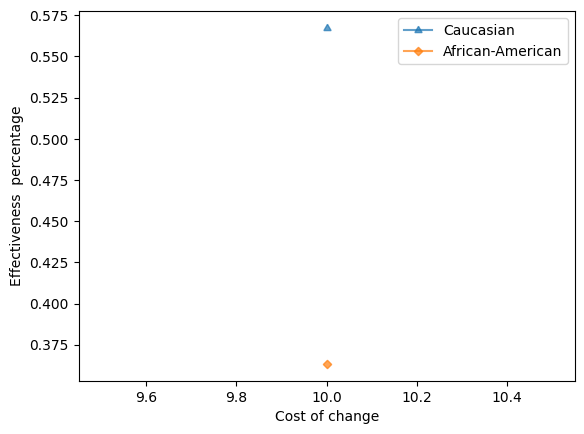

If age_cat = 25 - 45, sex = Male:
	Protected Subgroup 'Caucasian', 50.26% covered out of 262
		Make age_cat = Greater than 45 with effectiveness 54.08% and counterfactual cost = 10.
	Protected Subgroup 'African-American', 51.45% covered out of 483
		Make age_cat = Greater than 45 with effectiveness 33.08% and counterfactual cost = 10.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 1.95.
	Cumulative effectiveness plot for the above recourses:


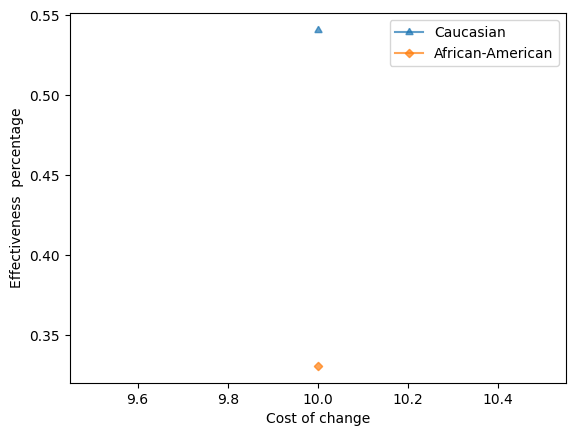

If c_charge_degree = F, sex = Male:
	Protected Subgroup 'Caucasian', 77.95% covered out of 262
		Make c_charge_degree = M with effectiveness 50.66% and counterfactual cost = 1.
	Protected Subgroup 'African-American', 80.66% covered out of 483
		Make c_charge_degree = M with effectiveness 34.53% and counterfactual cost = 1.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 1.87.
	Cumulative effectiveness plot for the above recourses:


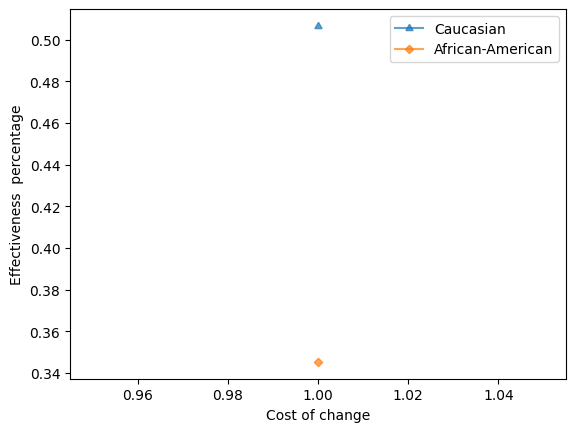

If c_charge_degree = F:
	Protected Subgroup 'Caucasian', 83.08% covered out of 262
		Make c_charge_degree = M with effectiveness 48.15% and counterfactual cost = 1.
	Protected Subgroup 'African-American', 86.46% covered out of 483
		Make c_charge_degree = M with effectiveness 32.66% and counterfactual cost = 1.
	 Unfairness based on the Fair Effectiveness-Cost Trade-Off = 1.85.
	Cumulative effectiveness plot for the above recourses:


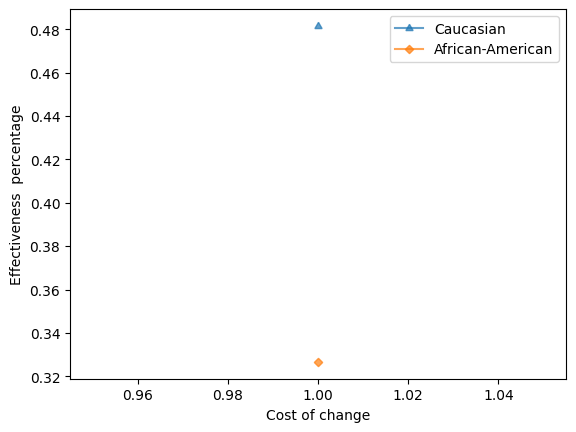

In [19]:
# taken from the other notebooks
affected_pop_sizes = {"African-American": 483, "Caucasian": 262}

top_rules,unfairness = facts.select_rules_subset_KStest(
    rules_with_cumulative_correctness,
    affected_pop_sizes,
    top_count=top_count
)

print_recourse_report_KStest_cumulative(
    top_rules,
    population_sizes=affected_pop_sizes,
    unfairness = unfairness,
    show_then_costs=True,
    show_cumulative_plots=True,
)

## Equal Effectiveness within Budget (Micro)

If juv_other_count = 3:
	Protected Subgroup 'Caucasian', 1.54% covered
		Make juv_other_count = 0 with effectiveness 66.67% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.16% covered
		Make juv_other_count = 0 with effectiveness 0.00% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.00
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.667.
	Cumulative effectiveness plot for the above recourses:


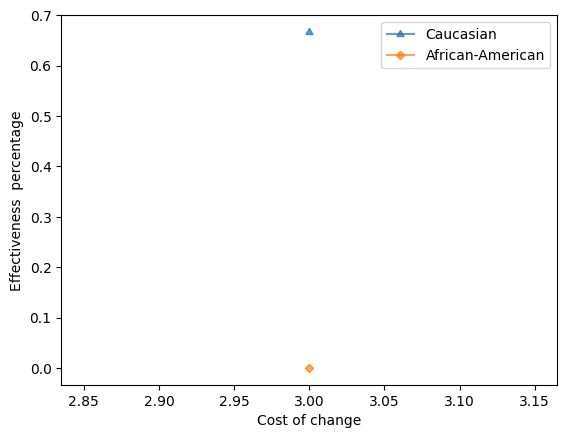

If age_cat = 10-25, juv_other_count = 1, priors_count = (1.0, 5.0]:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 66.67% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.67
	Protected Subgroup 'African-American', 1.93% covered
		Make juv_other_count = 0, priors_count = (-0.1, 1.0] with effectiveness 20.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.20
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.467.
	Cumulative effectiveness plot for the above recourses:


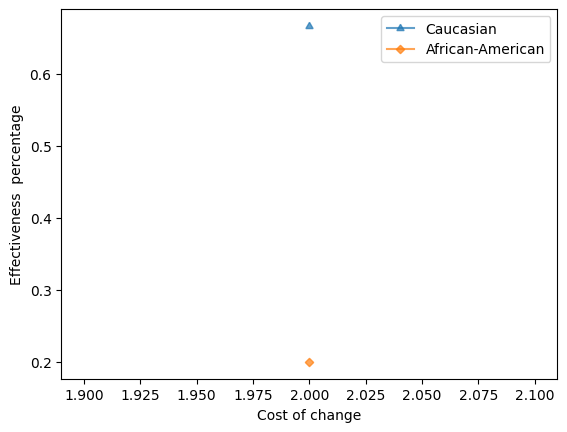

If age_cat = 25 - 45, c_charge_degree = F, juv_other_count = 1:
	Protected Subgroup 'Caucasian', 2.05% covered
		Make juv_other_count = 0 with effectiveness 25.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 75.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.75
	Protected Subgroup 'African-American', 3.87% covered
		Make juv_other_count = 0 with effectiveness 5.00% and counterfactual cost = 1.
		Make c_charge_degree = M, juv_other_count = 0 with effectiveness 30.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.30
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.45.
	Cumulative effectiveness plot for the above recourses:


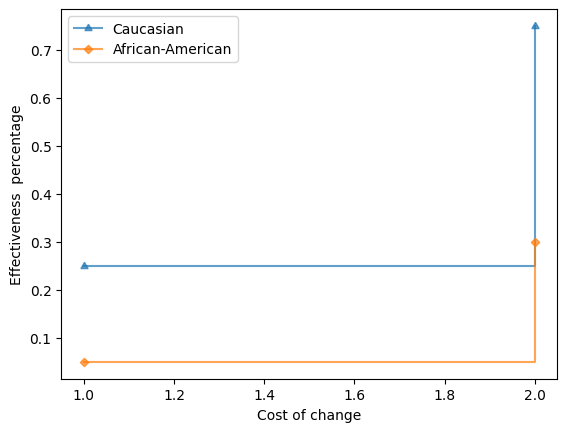

If age_cat = 10-25, c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, sex = Male:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 0.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.00
	Protected Subgroup 'African-American', 2.71% covered
		Make c_charge_degree = M, juv_misd_count = 0 with effectiveness 42.86% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.43
	Bias against African-American due to Equal Effectiveness. Unfairness score = 0.429.
	Cumulative effectiveness plot for the above recourses:


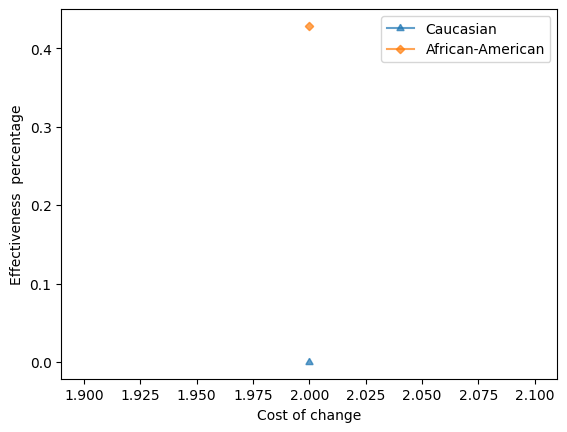

If age_cat = 10-25, juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 1.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 1.
		Aggregate cost of the above recourses = 0.08
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


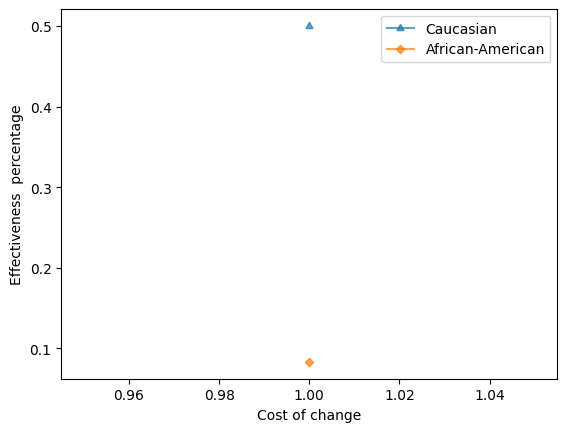

If juv_other_count = 1, priors_count = (-0.1, 1.0], sex = Male:
	Protected Subgroup 'Caucasian', 3.08% covered
		Make juv_other_count = 0 with effectiveness 50.00% and counterfactual cost = 1.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 2.32% covered
		Make juv_other_count = 0 with effectiveness 8.33% and counterfactual cost = 1.
		Make juv_other_count = 0, priors_count = (1.0, 5.0] with effectiveness 8.33% and counterfactual cost = 2.
		Aggregate cost of the above recourses = 0.08
	Bias against Caucasian due to Equal Effectiveness. Unfairness score = 0.417.
	Cumulative effectiveness plot for the above recourses:


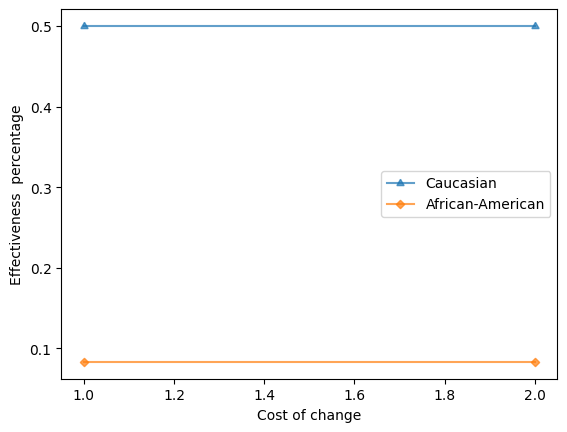

If c_charge_degree = F, juv_fel_count = 0, juv_misd_count = 1, priors_count = (5.0, 10.0]:
	Protected Subgroup 'Caucasian', 1.03% covered
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 0.00% and counterfactual cost = 2.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 50.00% and counterfactual cost = 3.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 50.00% and counterfactual cost = 3.
		Aggregate cost of the above recourses = 0.50
	Protected Subgroup 'African-American', 1.93% covered
		Make juv_misd_count = 0, priors_count = (1.0, 5.0] with effectiveness 10.00% and counterfactual cost = 2.
		Make juv_misd_count = 0, priors_count = (-0.1, 1.0] with effectiveness 80.00% and counterfactual cost = 2.
		Make c_charge_degree = M, juv_misd_count = 0, priors_count = (1.0, 

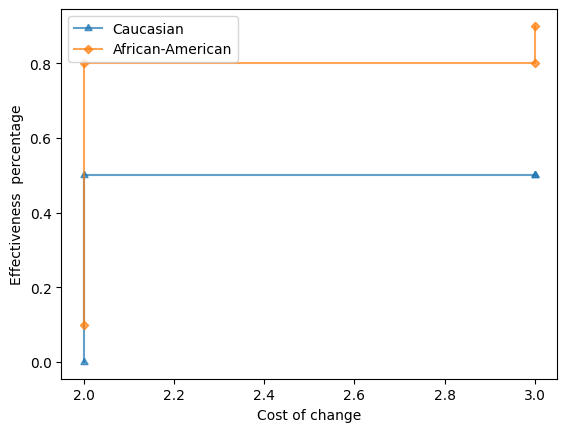

In [18]:
top_rules, subgroup_costs = facts.select_rules_subset_cumulative(
    rules_with_cumulative_correctness,
    metric="max-upto-cost",
    sort_strategy="generic-sorting-ignore-exists-subgroup-empty",
    top_count=top_count,
    cost_threshold = cost_budget,
    filter_sequence = [
        "remove-contained",
        "remove-fair-rules",
        "remove-above-thr-cost"
    ],
    params=params
)

print_recourse_report_cumulative(
    top_rules,
    subgroup_costs=subgroup_costs,
    show_subgroup_costs=True,
    show_then_costs=True,
    show_cumulative_plots=True,
    correctness_metric=False
)

## Get ranking of subgroups based on metrics

In [14]:
rules_with_both = {}
for ifc, all_thens in rules_with_cumulative_correctness.items():
    new_all_thens = {}
    for sg, (cov, thens_cum) in all_thens.items():
        thens_atom = rules_with_atomic_correctness[ifc][sg][1]
        thens_atom_dict = {then: atom_cor for then, atom_cor in thens_atom}
        new_all_thens[sg] = (cov, [(then, thens_atom_dict[then], cumcor) for then, cumcor, _cost in thens_cum])
    rules_with_both[ifc] = new_all_thens

In [15]:
from facts.fairness_metrics_aggr import make_table, auto_budget_calculation
budgets = auto_budget_calculation(rules_with_cumulative_correctness, cor_thres=0.5, percentiles=[0.3, 0.6, 0.9])

df = make_table(
    rules_with_both,
    sensitive_attribute_vals=["Caucasian", "African-American"],
    effectiveness_thresholds=[0.3, 0.7],
    cost_budgets=budgets,
    params=params
)

df.drop(['weighted-average', 'mean-cost-cinf'], axis=1, inplace=True)
df = df.loc[:, ~df.columns.duplicated()]


In [16]:
#table of differences between Male and Female for each metric
diff = get_diff_table(df, sensitive_attribute_vals=["Caucasian", "African-American"], with_abs = True)
diff = diff.set_index('subgroup')
ranked = diff.drop(columns=[('Fair Effectiveness-Cost Trade-Off','bias')]).mask(diff == 0).rank(ascending = False,axis=0,method='dense')
ranked = ranked.replace(np.nan,"Fair")

rev_bias_metrics = ['Equal Effectiveness', 'Equal Effectiveness within Budget']
comb_df = get_comb_df(df, ranked, diff, rev_bias_metrics, sensitive_attribute_vals=["Caucasian","African-American"])
diff_real_val, _, = get_diff_real_diff_drop(df, diff, sensitive_attribute_vals=["Caucasian", "African-American"])
analysis_df,rank_analysis_df = get_analysis_dfs(comb_df, diff_real_val, rev_bias_metrics, ranked, sensitive_attribute_vals=["Caucasian", "African-American"], percentage=0.1)

In [17]:
comb_df.head()

(Equal Cost of Effectiveness(Macro), 0.3)  \
                                                                                        rank   
subgroup                                                                                       
c_charge_degree = F                                                                     Fair   
c_charge_degree = F, juv_fel_count = 0                                                  Fair   
c_charge_degree = F, juv_misd_count = 0                                                 Fair   
c_charge_degree = F, sex = Male                                                         Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...                                      Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
c_charge_degree = F                                  0.0         Fair   
c_charge_degree = F, juv_fel_count = 0               0.0         Fair   
c_charge_degree = F, juv_misd_count = 0              0.0         Fair   
c_charge_degree = F, sex = Male                      0.0         Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...   0.0         Fair   

                                                   (Equal Cost of Effectiveness(Macro), 0.7)  \
                                                                                        rank   
subgroup                                                                                       
c_charge_degree = F                                                                     Fair   
c_charge_degree = F, juv_fel_count = 0                                                  Fair   
c_charge_degree = F, juv_misd_count = 0                                                 Fair   
c_charge_degree = F, sex = Male                                                         Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...                                      Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
c_charge_degree = F                                  0.0         Fair   
c_charge_degree = F, juv_fel_count = 0               0.0         Fair   
c_charge_degree = F, juv_misd_count = 0              0.0         Fair   
c_charge_degree = F, sex = Male                      0.0         Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...   0.0         Fair   

                                                   (Equal Choice for Recourse, 0.3)  \
                                                                               rank   
subgroup                                                                              
c_charge_degree = F                                                            Fair   
c_charge_degree = F, juv_fel_count = 0                                         Fair   
c_charge_degree = F, juv_misd_count = 0                                        Fair   
c_charge_degree = F, sex = Male                                                Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...                             Fair   

                                                                       \
                                                   score bias against   
subgroup                                                                
c_charge_degree = F                                  0.0         Fair   
c_charge_degree = F, juv_fel_count = 0               0.0         Fair   
c_charge_degree = F, juv_misd_count = 0              0.0         Fair   
c_charge_degree = F, sex = Male                      0.0         Fair   
c_charge_degree = F, juv_fel_count = 0, juv_mis...   0.0         Fair   

                                                   (Equal Cho

In [18]:
analysis_df

,Rank = 1 Count,Caucasian bias against Count,African-American bias against Count,Top 10% Caucasian bias against Count,Top 10% African-American bias against Count
"(Equal Cost of Effectiveness(Macro), 0.3)",51,37,82,0,11
"(Equal Cost of Effectiveness(Macro), 0.7)",46,19,43,0,6
"(Equal Choice for Recourse, 0.3)",13,108,98,12,8
"(Equal Choice for Recourse, 0.7)",15,31,113,8,6
Equal Effectiveness,1,99,416,14,37
"(Equal Effectiveness within Budget, 1.0)",4,97,365,16,30
"(Equal Effectiveness within Budget, 10.0)",1,117,474,20,39
"(Equal Cost of Effectiveness(Micro), 0.3)",51,37,82,0,11
"(Equal Cost of Effectiveness(Micro), 0.7)",46,19,43,0,6
Equal(Conditional) Mean Recourse,37,130,303,19,24


In [22]:
max_ranks = get_map_metric_to_max_rank(ranked)
rank_divided = get_other_ranks_divided(rank_analysis_df, max_ranks)
rank_divided

,"(Equal Cost of Effectiveness(Macro), 0.3)","(Equal Cost of Effectiveness(Macro), 0.7)","(Equal Choice for Recourse, 0.3)","(Equal Choice for Recourse, 0.7)",Equal Effectiveness,"(Equal Effectiveness within Budget, 1.0)","(Equal Effectiveness within Budget, 10.0)","(Equal Cost of Effectiveness(Micro), 0.3)","(Equal Cost of Effectiveness(Micro), 0.7)",Equal(Conditional) Mean Recourse,"(Fair Effectiveness-Cost Trade-Off, value)"
"(Equal Cost of Effectiveness(Macro), 0.3)",NaN,1.00,0.650,1.000,0.169,0.801,0.398,0.20,1.00,0.796,0.226
"(Equal Cost of Effectiveness(Macro), 0.7)",0.96,NaN,0.925,0.625,0.127,0.518,0.236,0.96,0.20,0.518,0.149
"(Equal Choice for Recourse, 0.3)",0.32,0.76,NaN,0.775,0.082,1.000,0.178,0.32,0.76,0.296,0.116
"(Equal Choice for Recourse, 0.7)",0.90,0.46,0.800,NaN,0.424,0.484,0.057,0.90,0.46,0.258,0.045
Equal Effectiveness,0.20,1.00,0.750,1.000,NaN,1.000,0.003,0.20,1.00,0.003,0.002
"(Equal Effectiveness within Budget, 1.0)",0.80,1.00,0.750,0.750,1.000,NaN,1.000,0.80,1.00,0.411,0.002
"(Equal Effectiveness within Budget, 10.0)",0.20,1.00,0.750,1.000,0.003,1.000,NaN,0.20,1.00,0.003,0.002
"(Equal Cost of Effectiveness(Micro), 0.3)",0.20,1.00,0.650,1.000,0.169,0.801,0.398,NaN,1.00,0.796,0.226
"(Equal Cost of Effectiveness(Micro), 0.7)",0.96,0.20,0.925,0.625,0.127,0.518,0.236,0.96,NaN,0.518,0.149
Equal(Conditional) Mean Recourse,0.98,1.00,1.000,1.000,0.507,0.772,0.512,0.98,1.00,NaN,0.627
